In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas_datareader.data as pdr
import yfinance as yf
yf.pdr_override()
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score

In [10]:
data =pd.read_pickle("finBERT_S&P.pkl").reset_index()
data_copy = data.copy()

# Create a new DataFrame with specific columns
new_df = data_copy[['Symbol','mostimportantdateutc','sentiment', 'sentiment_score']]
new_df.set_index('mostimportantdateutc', inplace=True)
print(new_df)

                     Symbol sentiment  sentiment_score
mostimportantdateutc                                  
2006-01-26                T  positive         0.939536
2006-04-25                T  positive         0.939940
2006-10-23                T  positive         0.936125
2006-12-20              ACN  positive         0.939088
2006-03-22             ADBE  positive         0.945004
...                     ...       ...              ...
2023-04-19             ZION  positive         0.931767
2023-02-14              ZTS  positive         0.911656
2023-05-04              ZTS  positive         0.914297
2023-02-22             EBAY  positive         0.861391
2023-04-26             EBAY  positive         0.738033

[29579 rows x 3 columns]


In [13]:
symbol = list(set(new_df['Symbol']))
print(len(symbol))

499


In [14]:
def make_oil_data(start, end):
    """
    get oil future price as well as pct_change data
    """
    print("Executing make_oil_data function...")
    oil = pdr.get_data_yahoo("CL=F", start, end)['Adj Close']
    oil_diff = pd.concat([oil.pct_change(i) for i in range(1, 5)], axis=1)
    oil_df = pd.concat([oil, oil_diff], axis=1)
    oil_df.columns = ['oil'] + ['oil_pct_' + str(i) for i in range(1, 5)]
    return oil_df

def make_gold_data(start, end):
    """
    get gold future price as well as pct_change data
    """
    print("Executing make_gold_data function...")
    data = pdr.get_data_yahoo("GC=F", start, end)['Adj Close']
    data_diff = pd.concat([data.pct_change(i) for i in range(1, 5)], axis=1)
    data_df = pd.concat([data, data_diff], axis=1)
    data_df.columns = ['gold'] + ['gold_pct_' + str(i) for i in range(1, 5)]
    return data_df

def make_currency_data(start, end):
    """
    Get usd/yen and usd/gbp and its log diff
    """
    print("Executing make_currency_data function...")
    currency_ticker = ["DEXJPUS", "DEXUSUK"]
    currency_data = pdr.DataReader(currency_ticker, "fred", start, end)
    currency_data = np.log(currency_data)
    currency_data.columns = ['LOG_' + '_'.join(col) if isinstance(col, tuple) else 'LOG_' + col for col in currency_data.columns]
    diffed_data_list = []
    for i in range(1, 5):
        diffed = currency_data.diff(i)
        diffed.columns = diffed.columns + '_DIFF_' + str(i)
        diffed_data_list.append(diffed)
    diffed_data_df = pd.concat(diffed_data_list, axis=1)
    return pd.concat([currency_data, diffed_data_df], axis=1)


def make_bond_data(start, end):
    """
    5, 10, and 30-year bond and year-over-year change
    """
    print("Executing make_bond_data function...")
    bond_list = ['^FVX', '^TNX', '^TYX']
    bond_price = pdr.get_data_yahoo(bond_list, start, end)['Adj Close']
    bond_yoy = np.log(bond_price).diff(252)
    bond_yoy.columns = bond_yoy.columns + '_log_yoy'
    return pd.concat([bond_price, bond_yoy], axis=1)

def make_vix(start, end):
    vix = pdr.DataReader('^VIX', 'yahoo', start, end)[['Close']]
    vix.columns = ['VIX']
    vix_rolling_max_Y = vix.rolling(252).max()
    vix_rolling_max_Y.columns = ['VIX_DD_Y']
    vix_rolling_max_Q = vix.rolling(60).max()
    vix_rolling_max_Q.columns = ['VIX_DD_Q']
    vix_rolling_max_M = vix.rolling(25).max()
    vix_rolling_max_M.columns = ['VIX_DD_M']
    vix_dd = pd.concat([vix_rolling_max_Y, vix_rolling_max_Q, vix_rolling_max_M], axis=1)
    return pd.concat([vix, vix_dd], axis=1)


def make_data(ticker, start, end):
    """
    Get ticker's future price as well as log return data.
    """
    data = yf.download(ticker, start=start, end=end, adjusted=True)['Adj Close']
    data_df = pd.concat([data], axis=1)
    data_df.columns = [ticker]
    return data_df

def make_open_close_mean_reversion(ticker, start, end):
    """
    open divided by close
    """
    print("Executing make_open_close_mean_reversion function...")
    df = pdr.get_data_yahoo(ticker, start, end).reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    lag_no = 10
    lagged_open = pd.concat([df['Open'].shift(i) for i in range(lag_no)], axis=1)
    out_df = (lagged_open / df['Close'].values[:, np.newaxis]) - 1
    out_df.columns = ['open_'+str(i)+'_div_close' for i in range(lag_no)]
    return out_df

def SMA_Minus_AdjClose(ticker, start, end):
    """
    from zichong
    """
    print("Executing SMA_Minus_AdjClose function...")
    ETF = pdr.get_data_yahoo(ticker, start, end).reset_index()
    ETF['Date'] = pd.to_datetime(ETF['Date'])
    ETF = ETF.set_index('Date')
    roll = 10
    sma = pd.concat([ETF['Adj Close'].rolling(3 * i).mean() for i in range(1, roll)], axis=1)
    out_df = sma - ETF['Adj Close'].values[:, np.newaxis]
    out_df.columns = ['sma'+str(3 * i)+'_minus_close' for i in range(1, roll)]
    return out_df

def make_RSI(ticker, start, end):
    """
    Make RSI of 28, 14, and 7 days
    """
    print("Executing make_RSI function...")
    ETF = pdr.get_data_yahoo(ticker, start, end).reset_index()
    ETF['Date'] = pd.to_datetime(ETF['Date'])
    ETF = ETF.set_index('Date')['Adj Close']

    def rsi(series, period):
        delta = series.diff().dropna()
        u = delta * 0
        d = u.copy()

        u[delta > 0] = delta[delta > 0]
        d[delta < 0] = -delta[delta < 0]

        u[u.index[period - 1]] = np.mean(u[:period])
        u = u.drop(u.index[:(period - 1)])

        d[d.index[period - 1]] = np.mean(d[:period])
        d = d.drop(d.index[:(period - 1)])

        rs = u.ewm(com=period - 1, adjust=False).mean() / \
             d.ewm(com=period - 1, adjust=False).mean()

        rsi = 100 - 100 / (1 + rs)
        rsi.name = 'RSI_' + str(period)
        return rsi

    return pd.concat([rsi(ETF, i) for i in [28, 14, 7]], axis=1)

def make_stoch(ticker, start, end, param_list=[10, 25, 60]):
    """
    Make stochastic oscillator
    """
    print("Executing make_stoch function...")
    ETF = pdr.get_data_yahoo(ticker, start, end).reset_index()
    ETF['Date'] = pd.to_datetime(ETF['Date'])
    ETF = ETF.set_index('Date')['Adj Close']

    def stoch_osc(data, window):
        stoch = data.rolling(window).apply(lambda x: (x.iloc[-1] - x.min()) / (x.max() - x.min()))
        stoch.name = 'stoch_osc_' + str(window)
        return stoch

    stoch_data = pd.concat([stoch_osc(ETF, i) for i in param_list], axis=1)
    return stoch_data

def make_macd(ticker, start, end):
    """
    Make MACD
    """
    print("Executing make_macd function...")
    def calculate_macd(data_series, fast, slow, signal, plot=True):
        macd_fast = data_series.ewm(span=fast).mean()
        macd_slow = data_series.ewm(span=slow).mean()
        macd = macd_fast - macd_slow
        macd_signal = macd.ewm(span=signal).mean()

        # Cut off anything before 2015
        macd_signal = macd_signal.loc[:]
        macd = macd.loc[:]

        macd.name = 'MACD'
        macd_signal.name = 'MACD Signal'

        macd_diff = macd - macd_signal
        macd_diff.name = 'MACD Diff'

        macd_df = pd.concat([macd, macd_signal, macd_diff], axis=1).loc[:]
        if plot:
            macd_df.plot(figsize=(16, 10))

        return macd_df

    ETF = pdr.get_data_yahoo(ticker, start, end).reset_index()
    ETF['Date'] = pd.to_datetime(ETF['Date'])
    ETF = ETF.set_index('Date')['Adj Close']

    return calculate_macd(ETF, 9, 12, 26, False)


def make_indexes_data(start, end):
    """
    Fetch other major equity market data from `Dow Jones Industrial Average`, `Russell2000`, 'NASDAQ', 'VIX', `FTSE100`,
    `CAC40`, `Nikkei 225`, `Cboe UK100`, `ESTX 50 EUR`, `HANG SENG INDEX`, `SHENZHEN INDEX`;
    """
    print("Executing make_indexes_data function...")
    indexes_ticker = ['^DJI', '^RUT', '^IXIC', '^VIX', '^FTSE', '^FCHI', '^N225', '^BUK100P', '^STOXX50E', '^HSI', '399001.SZ']
    indexes_data = pdr.get_data_yahoo(indexes_ticker, start, end)['Adj Close']
    indexes_data = np.log(indexes_data)
    indexes_data.columns = 'LOG_' + indexes_data.columns
    diffed_data_list = []

    for i in range(1, 5):
        diffed = indexes_data.diff(i)
        diffed.columns = diffed.columns + 'DIFF' + str(i)
        diffed_data_list.append(diffed)
    diffed_data_df = pd.concat(diffed_data_list, axis=1)
    return pd.concat([indexes_data, diffed_data_df], axis=1)

def make_kdj(ticker, start='2003-11-01', end='2022-10-31', n=10):
    """
    Make KDJ Oscillator
    """
    data = pdr.get_data_yahoo(ticker, start, end).reset_index()
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index('Date')
    close = data['Close']
    low = data['Low']
    high = data['High']

    def STOK(close, low, high, n):
        STOK = ((close - low.rolling(n).min()) /
                (high.rolling(n).max() - low.rolling(n).min())) * 100
        STOK.name = 'K%' + str(n)
        return STOK

    def STOD(close, low, high, n):
        STOK = ((close - low.rolling(n).min()) /
                (high.rolling(n).max() - low.rolling(n).min())) * 100

        STOD = STOK.rolling(3).mean()
        STOD.name = 'D%' + str(n)
        return STOD

    def STOJ(vSTOK, vSTOD, n):
        STOJ = vSTOK.dropna() - vSTOD.dropna()
        STOJ.name = 'J%' + str(n)
        return STOJ

    vSTOK = STOK(close, low, high, n)
    vSTOD = STOD(close, low, high, n)
    vSTOJ = STOJ(vSTOK, vSTOD, n)

    stoch_data = pd.concat([vSTOK, vSTOD, vSTOJ], axis=1)
    return stoch_data

In [5]:
importances_dict = {}
counter = 0  # initialize a counter

for i in symbol:
    try:
            start = new_df[new_df['Symbol'] == i].index[0]
            end = new_df[new_df['Symbol'] == i].index[-1] + datetime.timedelta(days=1)

            start_str = start.strftime('%Y-%m-%d')
            end_str = end.strftime('%Y-%m-%d')

            func_list_3_inputs = [make_data, make_macd, SMA_Minus_AdjClose]
            func_list_2_inputs = [make_oil_data, make_gold_data, make_bond_data]

            data_pool_3_inputs = pd.concat([func(i, start_str, end_str) for func in func_list_3_inputs], axis=1)
            data_pool_2_inputs = pd.concat([func(start_str, end_str) for func in func_list_2_inputs], axis=1)
            data_pool = pd.concat([data_pool_3_inputs, data_pool_2_inputs], axis=1)

            ticker = new_df[new_df['Symbol'] == i]
            ticker_with_data = ticker.join(data_pool.iloc[:, :], rsuffix='_data_pool')
            ticker_with_data[f'{i}_log_return'] = ticker_with_data[f'{i}'] / ticker_with_data[f'{i}'].shift(1)
            ticker_with_data = ticker_with_data.iloc[:, 1:]
            ticker_with_data['sentiment'] = ticker_with_data['sentiment'].replace({'positive': 1, 'neutral': 0, 'negative': -1})
            ticker_with_data.drop(i, axis=1, inplace=True)

            train_data, test_data = train_test_split(ticker_with_data, test_size=0.2, random_state=42)

            X = train_data.drop(f'{i}_log_return', axis=1)
            X = X.fillna(0)
            y = train_data[f'{i}_log_return']
            y = y.fillna(0)

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            rf_regressor = RandomForestRegressor()
            rf_regressor.fit(X_scaled, y)

            # Store feature importances in a list instead of a dictionary
            feature_importances = list(rf_regressor.feature_importances_)

            # Append feature importances to the importances_dict list
            importances_dict[counter] = [i] + feature_importances
            counter += 1  # increment the counter

    except Exception as e:
        print(f"Error occurred for symbol {i}. Skipping to the next iteration.")
        print(f"Error message: {str(e)}")
        continue

importances_df = pd.DataFrame.from_dict(importances_dict, orient='index', columns=['Symbol'] + X.columns.tolist())
importances_df.to_csv('importances.csv', index=False)

[*********************100%***********************]  1 of 1 completed
Executing make_macd function...
[*********************100%***********************]  1 of 1 completed
Executing SMA_Minus_AdjClose function...
[*********************100%***********************]  1 of 1 completed
Executing make_oil_data function...
[*********************100%***********************]  1 of 1 completed
Executing make_gold_data function...
[*********************100%***********************]  1 of 1 completed
Executing make_bond_data function...
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed
Executing make_macd function...
[*********************100%***********************]  1 of 1 completed
Executing SMA_Minus_AdjClose function...
[*********************100%***********************]  1 of 1 completed
Executing make_oil_data function...
[*********************100%***********************]  1 of 1 completed
Executing make_gol

C:\Users\final\AppData\Local\Temp\ipykernel_14884\3004459459.py:20: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ticker_with_data = ticker.join(data_pool.iloc[:, :], rsuffix='_data_pool')


[*********************100%***********************]  1 of 1 completed
Executing make_macd function...
[*********************100%***********************]  1 of 1 completed
Executing SMA_Minus_AdjClose function...
[*********************100%***********************]  1 of 1 completed
Executing make_oil_data function...
[*********************100%***********************]  1 of 1 completed
Executing make_gold_data function...
[*********************100%***********************]  1 of 1 completed
Executing make_bond_data function...
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed
Executing make_macd function...
[*********************100%***********************]  1 of 1 completed
Executing SMA_Minus_AdjClose function...
[*********************100%***********************]  1 of 1 completed
Executing make_oil_data function...
[*********************100%***********************]  1 of 1 completed
Executing make_gol

# Load the saved variable importance scores for the 499 tickers in S&P 500

In [7]:
importances_df

,Symbol,sentiment,sentiment_score,MACD,MACD Signal,MACD Diff,sma3_minus_close,sma6_minus_close,sma9_minus_close,sma12_minus_close,...,gold_pct_1,gold_pct_2,gold_pct_3,gold_pct_4,^FVX,^TNX,^TYX,^FVX_log_yoy,^TNX_log_yoy,^TYX_log_yoy
0,HOLX,0.000205,0.056764,0.099989,0.215539,0.067432,0.006299,0.003895,0.006359,0.006664,...,0.041035,0.033199,0.013540,0.028823,0.008213,0.102049,0.074307,0.010849,0.003388,0.007727
1,ORLY,0.000197,0.011086,0.070625,0.355213,0.023415,0.011410,0.048740,0.025375,0.015837,...,0.026570,0.025203,0.011977,0.016202,0.014817,0.010620,0.014508,0.009073,0.006442,0.011723
2,FI,0.003410,0.020163,0.016128,0.114080,0.011501,0.012221,0.003639,0.002031,0.002272,...,0.037832,0.011243,0.016553,0.009666,0.122633,0.049023,0.118394,0.015685,0.001613,0.010402
3,ACGL,0.000396,0.013493,0.083845,0.344032,0.014063,0.007169,0.004160,0.001911,0.008828,...,0.030194,0.005010,0.006250,0.002143,0.023956,0.012042,0.024700,0.023328,0.027172,0.043073
4,WBD,0.000230,0.013764,0.033076,0.242109,0.003581,0.009604,0.003794,0.017436,0.012919,...,0.007912,0.010438,0.026253,0.012359,0.037560,0.115184,0.042669,0.011946,0.018872,0.028362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,IP,0.004846,0.060238,0.014889,0.325854,0.006711,0.006094,0.002336,0.003458,0.007192,...,0.011532,0.022861,0.062013,0.060112,0.009649,0.028167,0.017834,0.006723,0.005441,0.010680
493,COO,0.006128,0.036862,0.019242,0.274072,0.007503,0.006730,0.006870,0.023576,0.011102,...,0.105441,0.096598,0.011614,0.009547,0.019621,0.008188,0.083046,0.011277,0.005315,0.008233
494,MSFT,0.000000,0.035256,0.030330,0.212794,0.042082,0.021384,0.017862,0.025157,0.048682,...,0.049588,0.043831,0.039788,0.030411,0.012758,0.014341,0.006979,0.033218,0.038113,0.009561
495,XEL,0.005918,0.019362,0.070746,0.307916,0.017368,0.018502,0.019086,0.027567,0.023388,...,0.014950,0.006417,0.006325,0.012380,0.034159,0.012850,0.026758,0.015873,0.010606,0.012571


In [2]:
importances_df= pd.read_csv('importances.csv')

In [3]:
importances_df

,Symbol,sentiment,sentiment_score,MACD,MACD Signal,MACD Diff,sma3_minus_close,sma6_minus_close,sma9_minus_close,sma12_minus_close,...,gold_pct_1,gold_pct_2,gold_pct_3,gold_pct_4,^FVX,^TNX,^TYX,^FVX_log_yoy,^TNX_log_yoy,^TYX_log_yoy
0,HOLX,0.000205,0.056764,0.099989,0.215539,0.067432,0.006299,0.003895,0.006359,0.006664,...,0.041035,0.033199,0.013540,0.028823,0.008213,0.102049,0.074307,0.010849,0.003388,0.007727
1,ORLY,0.000197,0.011086,0.070625,0.355213,0.023415,0.011410,0.048740,0.025375,0.015837,...,0.026570,0.025203,0.011977,0.016202,0.014817,0.010620,0.014508,0.009073,0.006442,0.011723
2,FI,0.003410,0.020163,0.016128,0.114080,0.011501,0.012221,0.003639,0.002031,0.002272,...,0.037832,0.011243,0.016553,0.009666,0.122633,0.049023,0.118394,0.015685,0.001613,0.010402
3,ACGL,0.000396,0.013493,0.083845,0.344032,0.014063,0.007169,0.004160,0.001911,0.008828,...,0.030194,0.005010,0.006250,0.002143,0.023956,0.012042,0.024700,0.023328,0.027172,0.043073
4,WBD,0.000230,0.013764,0.033076,0.242109,0.003581,0.009604,0.003794,0.017436,0.012919,...,0.007912,0.010438,0.026253,0.012359,0.037560,0.115184,0.042669,0.011946,0.018872,0.028362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,IP,0.004846,0.060238,0.014889,0.325854,0.006711,0.006094,0.002336,0.003458,0.007192,...,0.011532,0.022861,0.062013,0.060112,0.009649,0.028167,0.017834,0.006723,0.005441,0.010680
493,COO,0.006128,0.036862,0.019242,0.274072,0.007503,0.006730,0.006870,0.023576,0.011102,...,0.105441,0.096598,0.011614,0.009547,0.019621,0.008188,0.083046,0.011277,0.005315,0.008233
494,MSFT,0.000000,0.035256,0.030330,0.212794,0.042082,0.021384,0.017862,0.025157,0.048682,...,0.049588,0.043831,0.039788,0.030411,0.012758,0.014341,0.006979,0.033218,0.038113,0.009561
495,XEL,0.005918,0.019362,0.070746,0.307916,0.017368,0.018502,0.019086,0.027567,0.023388,...,0.014950,0.006417,0.006325,0.012380,0.034159,0.012850,0.026758,0.015873,0.010606,0.012571


In [4]:
mean_importances = importances_df.mean()
mean_importances_sorted = mean_importances.sort_values(ascending=False)
top_20_features = mean_importances_sorted[:20]
top_20_features

C:\Users\final\AppData\Local\Temp\ipykernel_2472\2908976969.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_importances = importances_df.mean()


MACD Signal          0.314864
MACD                 0.049026
gold                 0.042087
^TYX                 0.036842
sentiment_score      0.034949
oil                  0.034512
sma27_minus_close    0.033140
oil_pct_1            0.028662
sma3_minus_close     0.028051
oil_pct_4            0.026413
^FVX                 0.025140
gold_pct_1           0.024507
oil_pct_3            0.024432
oil_pct_2            0.023431
^TNX                 0.022698
gold_pct_2           0.021686
gold_pct_3           0.021522
gold_pct_4           0.021034
sma24_minus_close    0.020504
MACD Diff            0.020126
dtype: float64

In [5]:
print(mean_importances_sorted)

MACD Signal          0.314864
MACD                 0.049026
gold                 0.042087
^TYX                 0.036842
sentiment_score      0.034949
oil                  0.034512
sma27_minus_close    0.033140
oil_pct_1            0.028662
sma3_minus_close     0.028051
oil_pct_4            0.026413
^FVX                 0.025140
gold_pct_1           0.024507
oil_pct_3            0.024432
oil_pct_2            0.023431
^TNX                 0.022698
gold_pct_2           0.021686
gold_pct_3           0.021522
gold_pct_4           0.021034
sma24_minus_close    0.020504
MACD Diff            0.020126
sma6_minus_close     0.018473
sma9_minus_close     0.018401
sma12_minus_close    0.015928
sma21_minus_close    0.015348
sma15_minus_close    0.014976
^FVX_log_yoy         0.014803
^TYX_log_yoy         0.014710
sma18_minus_close    0.014382
^TNX_log_yoy         0.011408
sentiment            0.003922
dtype: float64


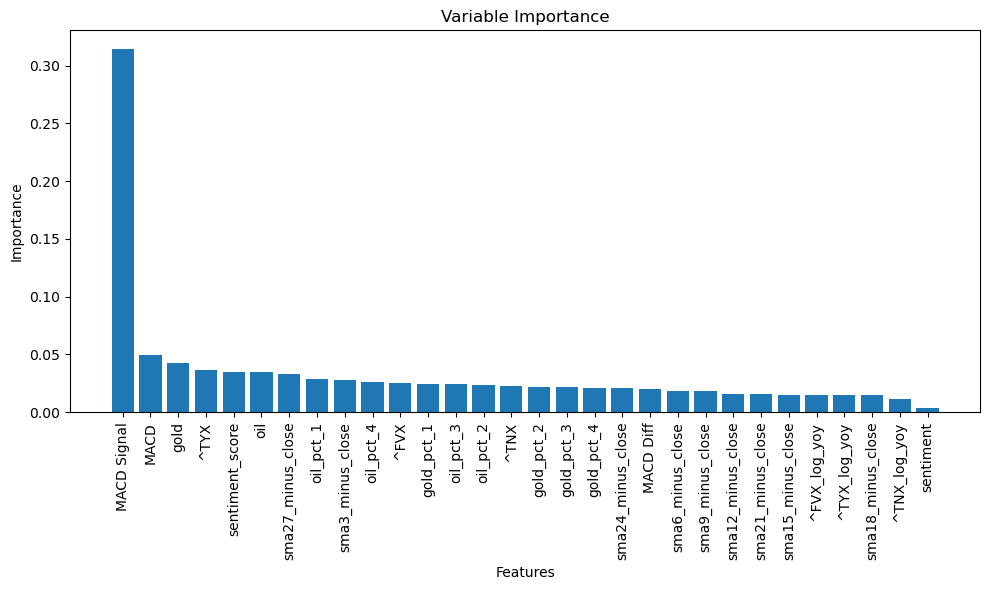

In [6]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the variable importances
plt.bar(mean_importances_sorted.index, mean_importances_sorted)

# Customize the plot
plt.title('Variable Importance')
plt.xlabel('Features')
plt.ylabel('Importance')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()


### Prediction for 5 stocks of interest

In [7]:
list_of_top_20_features=top_20_features.index.to_list()

In [8]:
list_of_top_20_features

['MACD Signal',
 'MACD',
 'gold',
 '^TYX',
 'sentiment_score',
 'oil',
 'sma27_minus_close',
 'oil_pct_1',
 'sma3_minus_close',
 'oil_pct_4',
 '^FVX',
 'gold_pct_1',
 'oil_pct_3',
 'oil_pct_2',
 '^TNX',
 'gold_pct_2',
 'gold_pct_3',
 'gold_pct_4',
 'sma24_minus_close',
 'MACD Diff']

In [11]:
list_of_stocks=['AAPL','AMZN','MSFT','TSLA','GOOG','NFLX']
AMZN=new_df[new_df['Symbol']==list_of_stocks[1]]
MSFT=new_df[new_df['Symbol']==list_of_stocks[2]]
TSLA=new_df[new_df['Symbol']==list_of_stocks[3]]
GOOG=new_df[new_df['Symbol']==list_of_stocks[4]]
NFLX=new_df[new_df['Symbol']==list_of_stocks[5]]

[*********************100%***********************]  1 of 1 completed
Executing make_macd function...
[*********************100%***********************]  1 of 1 completed
Executing SMA_Minus_AdjClose function...
[*********************100%***********************]  1 of 1 completed
Executing make_oil_data function...
[*********************100%***********************]  1 of 1 completed
Executing make_gold_data function...
[*********************100%***********************]  1 of 1 completed
Executing make_bond_data function...
[*********************100%***********************]  3 of 3 completed
AAPL Evaluation Metrics: RMSE: 0.1598203199743506, MSE: 0.025542534676703803
[*********************100%***********************]  1 of 1 completed
Executing make_macd function...
[*********************100%***********************]  1 of 1 completed
Executing SMA_Minus_AdjClose function...
[*********************100%***********************]  1 of 1 completed
Executing make_oil_data function...
[*********

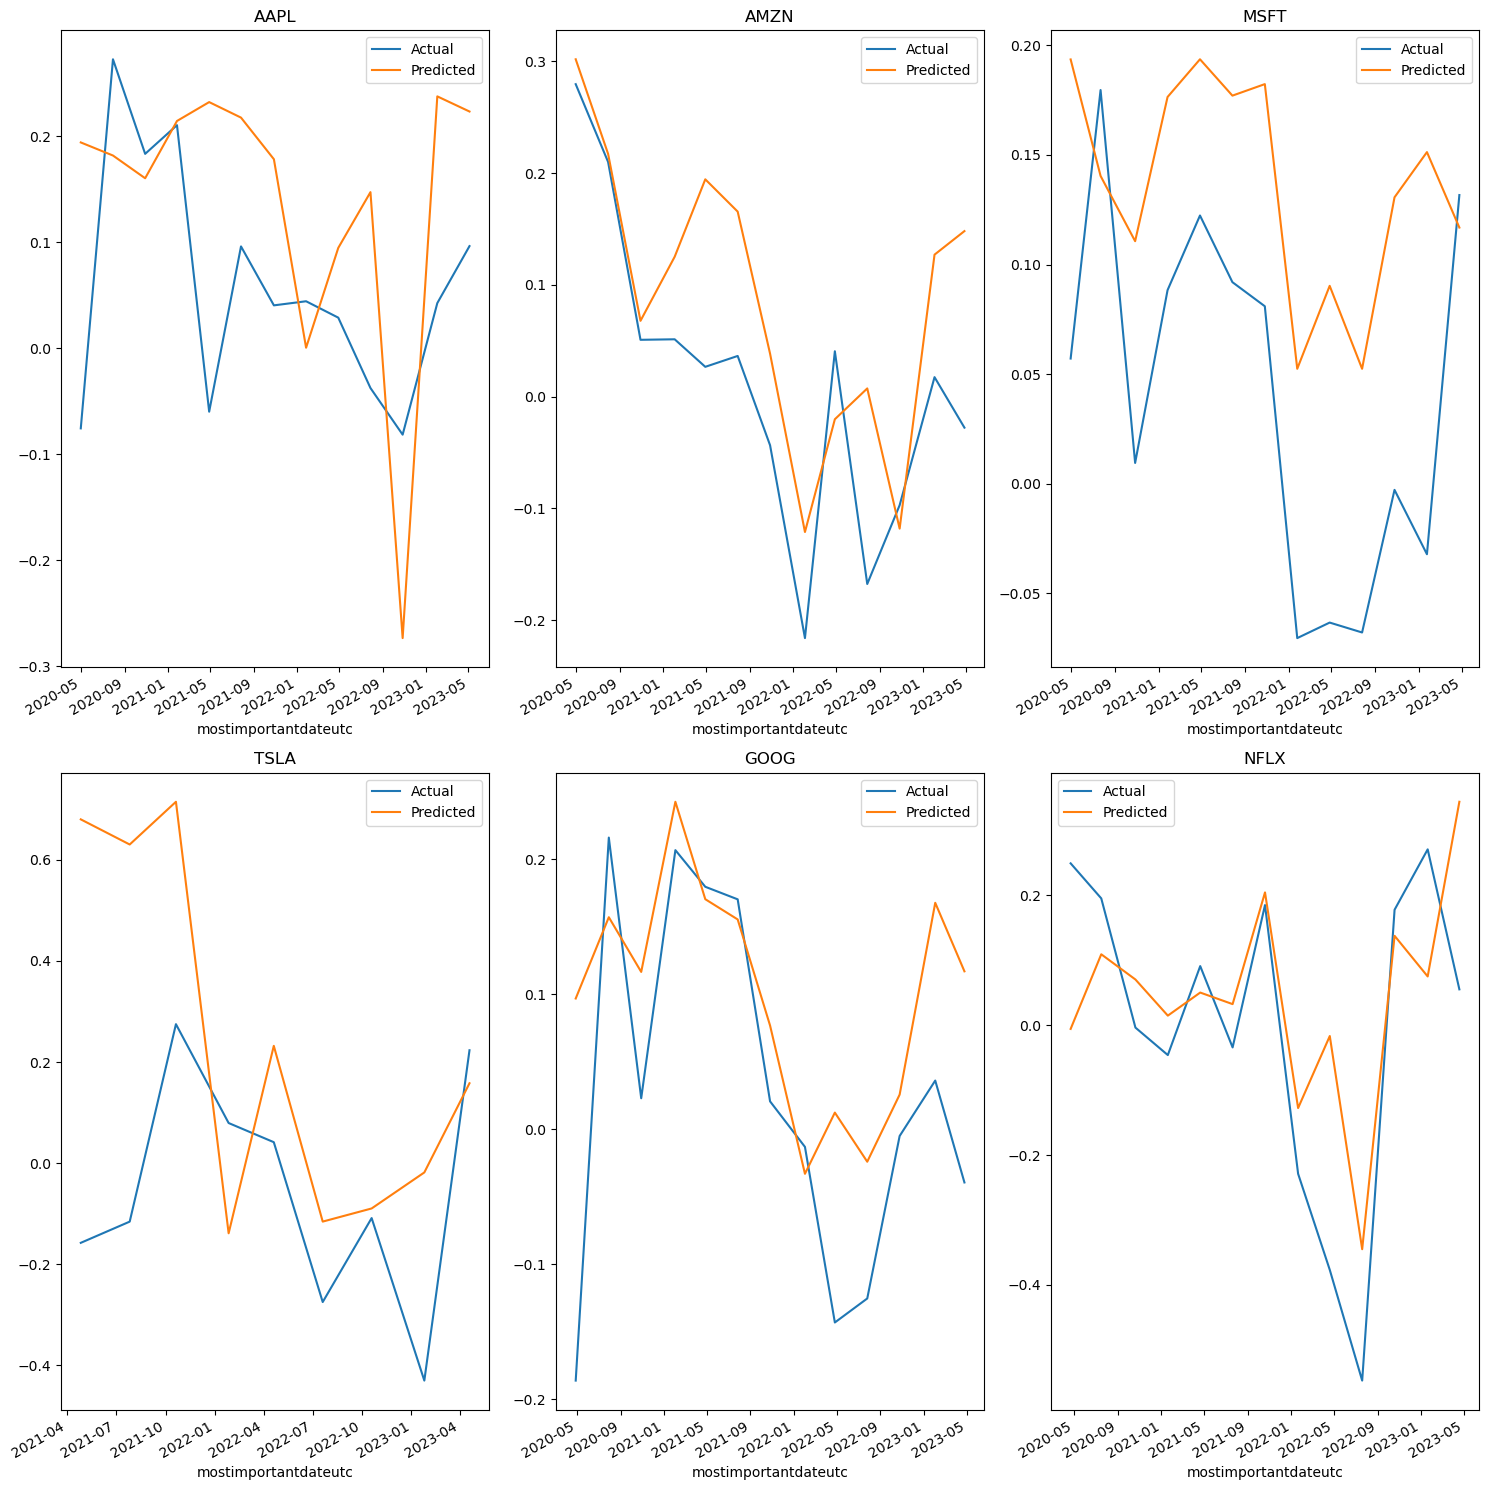

          RMSE       MSE
AAPL  0.159820  0.025543
AMZN  0.105432  0.011116
MSFT  0.112875  0.012741
TSLA  0.439102  0.192810
GOOG  0.115922  0.013438
NFLX  0.173777  0.030198


In [31]:
from sklearn.model_selection import GridSearchCV

evaluation_metrics = {}
list_of_stocks = ['AAPL', 'AMZN', 'MSFT', 'TSLA', 'GOOG', 'NFLX']
stocks_data = {}

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 15))

for i, stock in enumerate(list_of_stocks):
    stock_df = new_df[new_df['Symbol'] == stock]

    start = stock_df.index[0]
    end = stock_df.index[-1] + datetime.timedelta(days=1)

    start_str = start.strftime('%Y-%m-%d')
    end_str = end.strftime('%Y-%m-%d')

    func_list_3_inputs = [make_data, make_macd, SMA_Minus_AdjClose]
    func_list_2_inputs = [make_oil_data, make_gold_data, make_bond_data]

    data_pool_3_inputs = pd.concat([func(stock, start_str, end_str) for func in func_list_3_inputs], axis=1)
    data_pool_2_inputs = pd.concat([func(start_str, end_str) for func in func_list_2_inputs], axis=1)
    data_pool = pd.concat([data_pool_3_inputs, data_pool_2_inputs], axis=1)

    stock_with_data = stock_df.join(data_pool.iloc[:, :], rsuffix='_data_pool')
    stock_with_data = stock_with_data.dropna()
    stock_with_data['{}_log_return'.format(stock)] = np.log(stock_with_data[stock] / stock_with_data[stock].shift(1))
    stock_with_data = stock_with_data.iloc[:, 1:]
    selected_features = list_of_top_20_features + ['{}_log_return'.format(stock)]
    stock_with_data = stock_with_data[selected_features]

    stock_with_data = stock_with_data.dropna()

    # Determine the split point - for example, use 80% of the data for training
    split_point = int(len(stock_with_data) * 0.8)

    # Split the data
    train_data = stock_with_data[:split_point]
    test_data = stock_with_data[split_point:]

    # Split into features and targets
    X_train = train_data.drop('{}_log_return'.format(stock), axis=1)
    y_train = train_data['{}_log_return'.format(stock)]

    X_test = test_data.drop('{}_log_return'.format(stock), axis=1)
    y_test = test_data['{}_log_return'.format(stock)]

    # Apply standard scaling to the training and testing sets
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    # Hyperparameter tuning with GridSearchCV
    params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.01, 0.001]
    }

    xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
    grid_search = GridSearchCV(xgb_model, params, scoring='neg_mean_squared_error', cv=3)
    grid_search.fit(X_train, y_train)

    best_xgb_model = grid_search.best_estimator_

    # Predict on test data
    y_pred = best_xgb_model.predict(X_test)

    # Create a dataframe for actual and predicted values
    df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

    # Calculate the root mean square error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Calculate mean square error (MSE)
    mse = mean_squared_error(y_test, y_pred)

    print("{} Evaluation Metrics: RMSE: {}, MSE: {}".format(stock, rmse, mse))

    evaluation_metrics[stock] = [rmse, mse]

    # Plotting actual vs predicted values
    df.plot(ax=axs[i // 3, i % 3], title=stock)


plt.tight_layout()
plt.show()

# Converting dictionary to DataFrame
evaluation_df = pd.DataFrame.from_dict(evaluation_metrics, orient='index', columns=['RMSE', 'MSE'])
print(evaluation_df)
